In [330]:
import sys, os, numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx

sys.path.append(os.path.relpath("../../src/"))
from network import * # my class
import itertools
import pandas as pd
import numpy as np
import networkx as nx
import pylab as plt
from scipy.stats import norm,uniform,binom,poisson
import random
from functools import reduce
from collections import deque
import itertools
from uuid import uuid4
import seaborn as sns
import json 
from tqdm import tqdm

In [331]:
class Station(Node):
    def __init__(self, name, x, y):
        super().__init__()
        self.name = name
        self.line = set()
        self.x = x
        self.y = y
        self.cardinal_cycle = itertools.cycle([(0,1),(1,0),(0,-1),(-1,0)])
        self.back_tracks = 0
        
    def __repr__(self):
        return f'({str(self.x)},{str(self.y)})' + " || " + self.name
    
    def __str__(self):
        return self.__repr__()
    
    def cardinal_move(self, dir, epsilon = 0.01):
        self.move(epsilon*dir[0], epsilon*dir[1], True)
        
    @classmethod
    def make(cls, name, x, y):
        return cls(name, x, y)
    
class Connection(Edge):
    def __init__(self, station1, station2, line):
        super().__init__(station1, station2)
        self.line = line
        self.weight = lambda x : Node.dist(x.node1,x.node2)
        
    def __repr__(self):
        return str(self.line) + " || " + self.node1.name + " =#=#=#=#=#= " + self.node2.name
    
    def __str__(self):
        return self.__repr__()
    
    @classmethod
    def make(cls, station1, station2, line):
        return cls(station1, station2, line)
    
    
class Metro(Network):
    def __init__(self, stations, connections):
        super().__init__(stations, connections)
    
    
    def station_MSE(self, station, target_length = 1):
        adj_edges = [edge for edges in (i['edge'] for i in self.adj[station.id].values() if i['edge']) for edge in edges]
        error_vector = [(self._edge_translator[edge].weight - target_length)**2 for edge in adj_edges]
        return (sum(error_vector)/len(error_vector))**0.5
    
    def station_move(self, station, epsilon = 0.01, max_back_tracks = 1000, target_length = 1):
        if station.back_tracks > max_back_tracks:
            return 'stuck'
        dir = next(station.cardinal_cycle)
        error = self.station_MSE(station, target_length)
        station.cardinal_move(dir, epsilon)
        if self.station_MSE(station, target_length) < error:
            station.back_tracks +=1
            station.cardinal_move(dir, -epsilon)
            return 
        station.back_tracks = 0
        return 

In [332]:
with open('clean_metro_data.json', 'r') as fp: 
    line_dict = json.load(fp)
    line_dict = {int(key): value for key, value in line_dict.items()}

In [333]:
complete_lines = {}
for k in range(1,11):
    complete_lines[k] = []
    for i , j in enumerate(line_dict[k]):
        if j[1]:
            if j[1][0] >= k:
                complete_lines[k].append((k,i,1,line_dict[k][i][0]))
            else:
                val = reduce(lambda x,y : x if x[0] == j[0] else y,line_dict[j[1][0]])
                complete_lines[k].append((j[1][0],line_dict[j[1][0]].index(val),1,line_dict[k][i][0]))
        else:
            complete_lines[k].append((k,i,1,line_dict[k][i][0]))

In [334]:
stations = []
station_locs = []
connections = []
visited_stations = {}
name_to_station = {}
for i in range(1,11):
    path = complete_lines[i]
    for j in range(len(path)-1):
        loc1 = (path[j][0],path[j][1])
        loc2 = (path[j+1][0],path[j+1][1])
        
        if loc1 not in station_locs:
            station1 = Station.make(path[j][3],*loc1)
            station_locs.append(loc1)
            stations.append(station1)
            name_to_station[path[j][3]] = station1.id
            station1.line.add(i)
        else: 
            station1 = stations[station_locs.index(loc1)]
            station1.line.add(i)
            
            
        if loc2 not in station_locs:
            station2 = Station.make(path[j+1][3],*loc2)
            station_locs.append(loc2)
            stations.append(station2)
            name_to_station[path[j+1][3]] = station2.id
            station2.line.add(i)
        else:
            station2 = stations[station_locs.index(loc2)]
            station2.line.add(i)

        connections.append(Connection.make(station1,station2,i))


madrid_metro = Metro(stations,connections)

In [335]:
station_data_before_optimization = []
for i in madrid_metro.nodes:
    station_data_before_optimization.append([i.name,i.x,i.y,min(i.line)])
    
station_data_before_optimization = pd.DataFrame(station_data_before_optimization,columns = ['name','x','y','line'])
station_data_before_optimization.to_csv('station_data_before_optimization.csv',index = False)

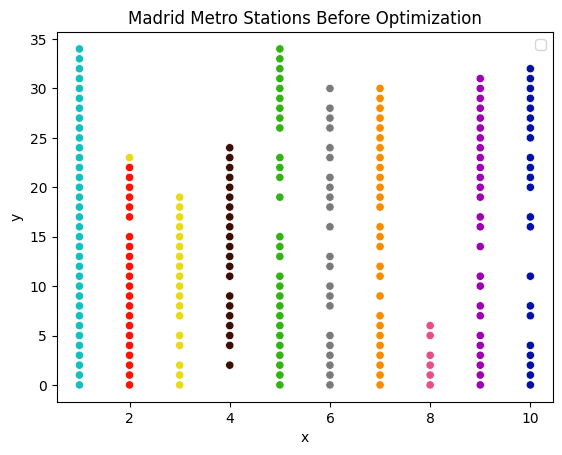

In [336]:
palette ={1: "#13bfbf", 2: "#fa1302", 3: "#e8da15", 4: "#3d0e05",5: "#33b314", 6: "#7a7a7a", 7: "#f78c00", 8: "#e65087", 9: "#9c02b0", 10: "#0311a6"}
sns.scatterplot(data=station_data_before_optimization, x='x', y='y', hue='line', palette=palette)
plt.title('Madrid Metro Stations Before Optimization')
plt.legend('')
plt.savefig('station_data_before_optimization.png')
plt.show()

In [337]:
with open('End_Stations_Coordinates_clean.json', 'r') as fp:
    end_coords = json.load(fp)

In [338]:
pile = madrid_metro.nodes[:]
for key, value in end_coords.items():
    x = name_to_station.get(key)
    y = madrid_metro._node_translator[x]
    pile.remove(y)
    y.move(value[0],value[1],rel=False)

In [339]:
madrid_metro

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Network with 228 Nodes and 265 Edges
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Nodes:
(39.90860624521267,68.93969777716241) || pinar de chamartin
(1,1) || bambu
(1,2) || chamartin
(1,3) || plaza de castilla
(1,4) || valdeacederas
(1,5) || tetuan
(1,6) || tetuan
(1,7) || estrecho
(1,8) || alvarado
(29.702970297041638,55.918351936817594) || cuatro caminos
(1,10) || rios rosas
(1,11) || iglesia
(1,12) || bilbao
(1,13) || tribunal
(1,14) || centro
(1,15) || gran via
(1,16) || sol
(1,17) || tirso de molina
(1,18) || anton martin
(1,19) || atocha
(1,20) || retiro
(1,21) || menendez pelayo
(1,22) || pacifico
(1,23) || puente de vallecas
(1,24) || nueva numancia
(1,25) || portazgo
(1,26) || buenos aires
(1,27) || alto del arenal
(1,28) || miguel hernandez
(1,29) || sierra de guadalupe
(1,30) || villa de vallecas
(1,31) || congosto
(1,32) || la gavia
(1,33) || las suertes
(60.091393755189166,21

In [340]:
station_data_move_ends = []
for i in madrid_metro.nodes:
    station_data_move_ends.append([i.name,i.x,i.y,min(i.line)])
    
station_data_move_ends = pd.DataFrame(station_data_move_ends,columns = ['name','x','y','line'])
station_data_move_ends.to_csv('station_data_move_ends.csv',index = False)

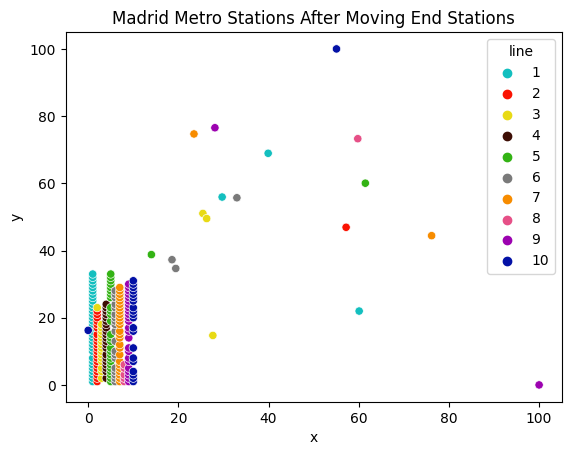

In [341]:
sns.scatterplot(data=station_data_move_ends, x='x', y='y', hue='line', palette=palette)
plt.title('Madrid Metro Stations After Moving End Stations')
plt.savefig('station_data_move_ends.png')
plt.show()

In [353]:
pile_copy = pile[:]

for i in tqdm(range(1000)):
    for station in pile_copy:
        x = madrid_metro.station_move(station,
                                      epsilon=0.5,
                                      max_back_tracks=1000,
                                      target_length=2)
        if x == 'stuck':
            pile_copy.remove(station)
            

100%|██████████| 1000/1000 [00:06<00:00, 164.12it/s]


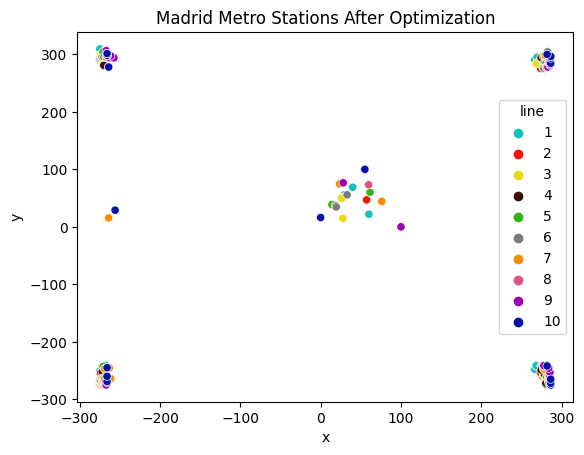

In [354]:
station_data_post_optimization = []
for i in madrid_metro.nodes:
    station_data_post_optimization.append([i.name,i.x,i.y,min(i.line)])
    
station_data_post_optimization = pd.DataFrame(station_data_post_optimization,columns = ['name','x','y','line'])
station_data_post_optimization.to_csv('station_data_post_optimization.csv',index = False)

sns.scatterplot(data=station_data_post_optimization, x='x', y='y', hue='line', palette=palette)
plt.title('Madrid Metro Stations After Optimization')
plt.savefig('station_data_post_optimization.png')
plt.show()

In [344]:
print(len(pile_copy))

209


In [350]:
madrid_metro

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Network with 228 Nodes and 265 Edges
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Nodes:
(39.90860624521267,68.93969777716241) || pinar de chamartin
(-25.0,-25.0) || bambu
(-25.0,-24.0) || chamartin
(-25.0,-23.0) || plaza de castilla
(25.0,30.0) || valdeacederas
(25.0,30.0) || tetuan
(-21.5,-15.5) || tetuan
(23.0,28.5) || estrecho
(-25.0,-18.0) || alvarado
(29.702970297041638,55.918351936817594) || cuatro caminos
(-25.0,-16.0) || rios rosas
(26.5,37.5) || iglesia
(-25.0,38.5) || bilbao
(-25.0,39.5) || tribunal
(-25.0,39.5) || centro
(-25.0,41.5) || gran via
(-25.0,42.5) || sol
(-25.0,42.5) || tirso de molina
(-25.0,42.5) || anton martin
(-25.0,42.5) || atocha
(16.5,2.0) || retiro
(16.5,40.5) || menendez pelayo
(-25.0,-1.0) || pacifico
(19.5,45.0) || puente de vallecas
(19.5,45.0) || nueva numancia
(-18.0,9.0) || portazgo
(-18.0,9.0) || buenos aires
(18.0,9.0) || alto del arenal
(18.5,8.5)